# 3. Preparado de los Datos
A lo largo de este notebook se cubre la tercera fase de la metodología CRIPS-DM, en este caso la preparación del conjunto de datos.

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo y requisitos del proyecto, traduciendo las necesidades a una definición analítica del problema y una estrategia para abordarlo.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos.


3. <span style="color:#66FF99;">**Preparación de los Datos (Data Preparation)** </span> 
   - Consistente en la limpieza, preparación y extracción de características de los datos, de vital importancia para el modelado dado que determinará la calidad de los datos.

4. **Modelado (Modeling)**  
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.Evaluación de los resultados obtenidos por el modelo, determinando si cumple con los requisitos definidos en la primera de las fases y si es factible su implementación.
   
6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.



## 1. Data preparation

Una vez cargado y estudiado el conjunto de datos, pasamos a limpiar, preprocesar y extraer características de mismos para obtener un modelo de mejor calidad. Es por ello que este apartado se divide en dos etapas:

1. Muestreado y preprocesamiento de las imágenes

2. Generación de imágenes derivadas de las actuales y desarrolo de técnicas de data augmentation


### 1.1 Sampleado del conjunto de datos

Este primer apartado tiene como objetivo solventar una de las grandes deficiencias localizadas en el apartado anterior, el desbalanceo de las clases en nuestro dataset de imágenes.

A lo largo de esta primera parte del noteobook se procederá a la realización del sampleo de instancias del dataset inicial, dando como salida en este caso un objeto dataset nativo de tensorflow `tf.dataset`, que permitirá que el entrenamierto del modelo sea lo más rápido posible. Los objetivos de este apartado serán varios:

- La eliminación las máscaras demasiado pequeñas consideradas redundanter presentes en el dataset y práctica,mente inperceptibles, fruto de un mal etiquetado, para facilitar el aprendijaze del modelo.

- Elimimnación de instancias con únicamente fondo, consideradas como irrelevantes para el aprendizaje del modelo, cuyo bottleneck del entrenamiento se trata de la capacidad de cómputo y este tipo de instancias lo limitan.

- La obtención de un conjunto de entrenamieto más balanceado, que facilitarán el funcionamiento de la función de pérdida.

In [ ]:
from pathlib import Path
from utils import  load_yaml_file, download_zip
import os

import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import numpy as np
import random

import tensorflow as tf

import matplotlib.patches as mpatches

from tqdm import tqdm


from pycocotools.coco import COCO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os


import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

from utils import generar_mascara_one_hot, plot_one_hot_encoded_masks, generar_mascara, plot_image_and_mask

In [ ]:
yaml=load_yaml_file()
objetives=yaml["objetive_classes"]
N_CLASSES=len(objetives)+1

In [ ]:
DIR_TRAIN_ANNOTATIONS=yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS=yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS=os.path.abspath(os.path.join(os.getcwd(), "..", DIR_TRAIN_IMGS))

coco=COCO(os.path.join(os.getcwd(),"..",DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=23.58s)
creating index...
index created!


A continuación, se definen algunas EEDD que ayudan a un uso ágil de funciones de ploteo, sirviendo como diccionario entre identificadores de COCO nativos y la clase asociada a la misma, el identificador de nuestro canal de la máscara y el nombre asociado, etc.

In [26]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]
category_info_objetive = {i:category_info_id[i] for i in id_objetives}
category_info_objetive[0] = "background"
categories_names_by_index = { i: category_info_objetive[id_cat] for i , id_cat in enumerate(sorted(category_info_objetive.keys()))}


dict_class_index = {key:i for i , key in enumerate(sorted(category_info_objetive.keys()))}
mapper_indexModel_index_result = {value:i for i, value in enumerate(sorted(category_info_objetive.keys()))}

dict_channel_name = {i:category_info_objetive[key] for i, key in enumerate(sorted(category_info_objetive.keys()))}



En primer lugar se descartan todas aquellas muestras que no contengan clases objetivo, conteniendo unicamente fondo. 

Del conjunto que contienen al menos una clase, definimos un umbral minimo y vemos si la suma de pixeles que supone la totalidad de las máscaras es o no significativa para nuestro conjunto de entrenamiento.

In [27]:

img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)


print(f"Las cantidad de imagenes con al menos una clase es de {len(img_ids)}")

Las cantidad de imagenes con al menos una clase es de 79542




Además, se hace uso de alguna de las funciones definidas en el fichero `utils.py`, que ofrecen métodos tanto para la generación de objetos `np.array` de imágenes y máscaras dado el id de la imagen como para la visualización de los mismos.


In [ ]:
img, mask = generar_mascara_one_hot(coco, image_id= img_ids[0], path_images = DIR_TRAIN_IMGS, ids_masks = id_objetives)

Además, se genera una función que genera de una imagen la clase `fondo`, aquella que se corresponderá con cada uno de los píxeles no etiquetados en la imagen, y que permitirá entrenar el modelo de forma correcta.

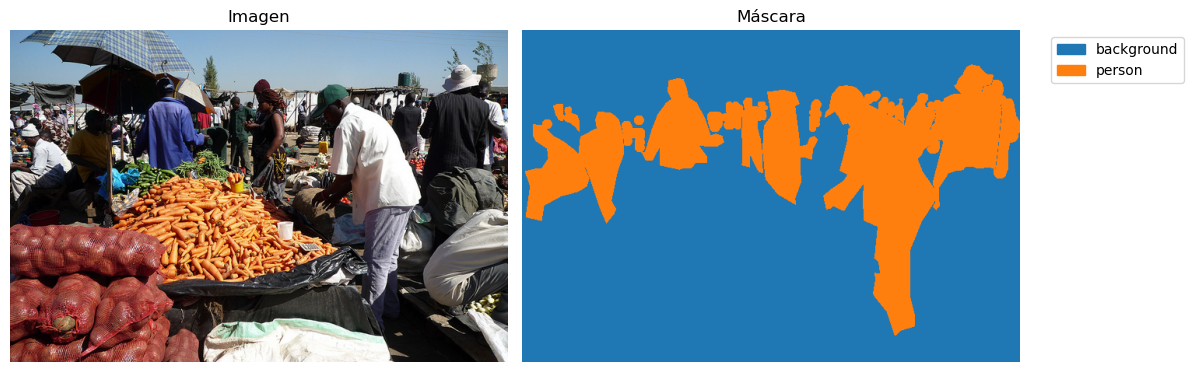

In [29]:
plot_one_hot_encoded_masks(img, mask, category_info_objetive)

Comprobados los resultados, generamos el objeto `tf.dataset` que nos permitirá una carga más rápida en memoria a la hora de entrenar nuetro modelo. Además, este tipo de objetos es más portable de cara a cargarse en un entorno cloud, que podrá ser usado a futuro si se requieren mayores capacidades computacionales, al carecer de GPU.


Se decide obtener un conjunto de un batch base de 16 para la generación de esta estructura de datos tanto para train como para test

In [ ]:
tfrecord_path_train=r"C:\Users\ruben\Desktop\code_tfm\src\dataset_train.tfrecord"
tfrecord_path_test=r"C:\Users\ruben\Desktop\code_tfm\src\dataset_test.tfrecord"

batch_size = 16
total_id_images = img_ids[:batch_size*(len(img_ids)//batch_size)]

In [ ]:
proportion_train_test=0.95
n_batches_train =round((len(total_id_images)//batch_size)*proportion_train_test)

train_image_ids=random.sample(total_id_images, n_batches_train*batch_size)
test_image_ids=[item for item in total_id_images if item not in train_image_ids]

## 2. Generación de imágenes derivadas de las actuales


En esta segunda fase, serán varias las técnicas empleadas para aumentar la cantidad y mejorar la calidad de los datos de tal forma que se fuerce a nuestro modelo a la genralización. Estas técnicas son las siguientes:

1) Cropping de máscaras:inclusión de recortes de otras imágenes que eviten el desvalanceo de clases.

2) Data augmentation: generación de un procedimiento que altera levemente las imágenes y corrige sus máscaras asociadas para la obtención de nuevas imágenes que eviten el sobreajuste del modelo.

### 2.1 Random cropping


Para la generación de un dataset menos desvalanceado que el generado se ha decidido aplicar `cropping` aleatorio de máscaras que permitirán mayor presencia de las clases minoritarias en las imágenes, haciendo que tomen importancia en las métricas de error definidas para los modelos y así evitar un sobreajuste del modelo en clases mayoritarias.

Dado que las imágenes son de tamaño variable, es necesario definir una función que permita adaptar el tamaño de tanto la máscara como la imagen ante la inclusióin de croppings que no caben debido a sus dimensiones la imagen target.

In [32]:
def redimensionar_recorte(img, mask, target_shape):

    input_alt,input_anc,_= img.shape
    target_alt,target_anc,_= target_shape

    recorte= img[:min(input_alt, target_alt),:min(input_anc, target_anc), :]
    mascara_recorte =mask[:min(input_alt, target_alt),:min(input_anc, target_anc)]

    padding_top = max(target_alt-recorte.shape[0],0)
    padding_dcha = max(target_anc-recorte.shape[1],0)

    padded = np.pad(recorte,((padding_top, 0),(0,padding_dcha),(0,0)),mode='constant',constant_values=0)
    padded_mascara = np.pad(mascara_recorte,((padding_top,0),(0,padding_dcha)),mode='constant',constant_values=0)

    return padded, padded_mascara

A continuación se define la función que permite la inserción de una máscara de una immagen aleatoria, generando la nueva imagen y máscaras con los recortes

In [36]:
CONST_THRESHOLD_SIZE_CROPPING = 300

def insertar_mascara_random(img, mask_orig, target_class, target_channel):


    while True:

        img_ids =  coco.getImgIds(catIds=[target_class])
        target_id = random.choice(img_ids)
        target_info  = coco.loadImgs(target_id)[0]
        target_path  = os.path.join(DIR_TRAIN_IMGS,target_info['file_name'])
        target = cv2.imread(target_path)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        ann_ids = coco.getAnnIds(imgIds=target_id,  catIds=[target_class],  iscrowd=False)
        anns = coco.loadAnns(ann_ids)
        ann = random.choice(anns)
        mascara_target = coco.annToMask(ann)


        shape = img.shape
        target, mascara_target = redimensionar_recorte(target,mascara_target,shape)

        if np.sum(mascara_target) > CONST_THRESHOLD_SIZE_CROPPING:
            break 

    bool_mascara_3d = mascara_target[:,:,np.newaxis]
    result_imagen = np.where(bool_mascara_3d,target,img)
    mask_orig[mascara_target.astype(bool)] = target_channel


    return result_imagen, mask_orig

Asimismo, se define una cosntante que indica el número de máscaras que se insertarán en esta fase de cropping por imágen para favorecer al balanceo.

In [ ]:
CONS_N_CROPPINGS=3

Se representa un primer ejemplo para validar el resultado:

In [ ]:
img, mask = generar_mascara(coco, train_image_ids[0],ids_masks= id_objetives ,path_images=DIR_TRAIN_IMGS)
mask=np.vectorize(lambda x:dict_class_index.get(x,x))(mask)
img = np.array(img)
for _ in range(CONS_N_CROPPINGS):
    class_cropping = random.choice(id_objetives)
    target_channel = mapper_indexModel_index_result[class_cropping]
    img, mask = insertar_mascara_random(img, mask, class_cropping,target_channel )
    #print(np.unique(mask))

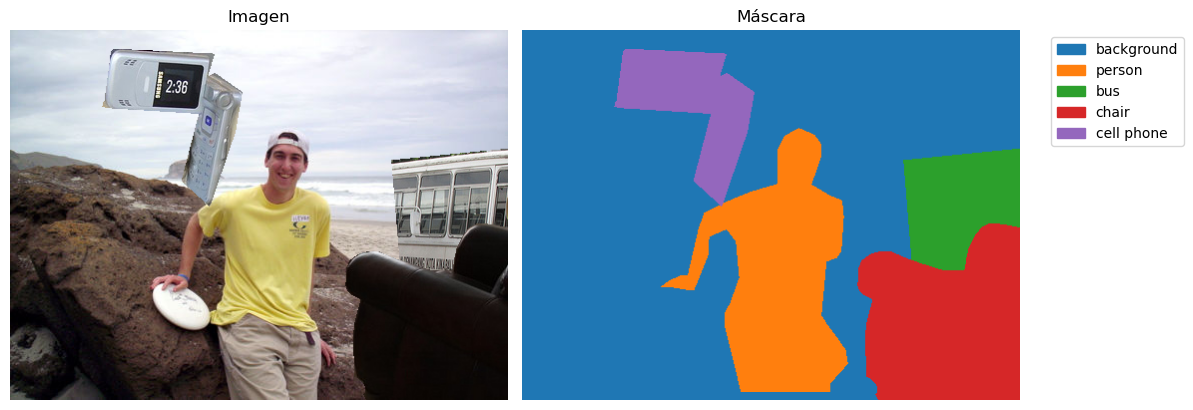

In [43]:
plot_image_and_mask(img,mask,dict_channel_name)

Se genera una función para serializar tanto el dataset completo tanto de train como de test, que volcará los datos como un objeto de la clase `tf.Dataset`. Dado que las dimensiones son variables, es necesario el almacenamiento de las dimensiones cada imagen para su reconastrucción.

Es importante destacar los castings de las máscaras a tipos de datos como `np.uint8`, que permitirán una reducción de memoria muy significativa de cara a ser cargados por Google Drive para su entrenamiento en colab con GPU.

In [ ]:
def serializar_imagen(img_id, coco,path_images, id_objetives ):

    img, mask = generar_mascara(coco, img_id, ids_masks= id_objetives  ,path_images = path_images)
    #print("masl", np.unique(mask))
    mask=np.vectorize(lambda x:dict_class_index.get(x,x))(mask)
    img = np.array(img)
    for _ in range(CONS_N_CROPPINGS):
        class_cropping = random.choice(id_objetives)
        target_channel = mapper_indexModel_index_result[class_cropping]
        img, mask = insertar_mascara_random(img, mask, class_cropping,target_channel)

    # print("shape", mask.shape)
    # print("masl", np.unique(mask))

    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST) 
    img_codificada = tf.io.encode_jpeg(img).numpy() 
    mask = mask.astype(np.uint8)
    mask_raw = mask.tobytes()
    mask_shape = list(mask.shape) 
   

    feature = {
        "image":tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_codificada])),
        "mask":tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask_raw])),
        "mask_shape":tf.train.Feature(int64_list=tf.train.Int64List(value=mask_shape))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

with tf.io.TFRecordWriter(tfrecord_path_train) as writer:
    for img_id in tqdm(train_image_ids, desc="Generando Conjunto de datos Train"):
        example = serializar_imagen(img_id,coco,DIR_TRAIN_IMGS, id_objetives)
        writer.write(example)

with tf.io.TFRecordWriter(tfrecord_path_test) as writer:
    for img_id in tqdm(test_image_ids, desc="Generando Conjunto de datos Test"):
        example = serializar_imagen(img_id, coco,DIR_TRAIN_IMGS, id_objetives)
        writer.write(example)

Generando Conjunto de datos Train:   0%|          | 0/75552 [00:00<?, ?it/s]

Generando Conjunto de datos Test: 100%|██████████| 3984/3984 [13:08<00:00,  5.05it/s]


Asimismo, se genera una función que permite la carga del `tf.Dataset` por batches de np.arrays. 

In [ ]:
def parse_tfrecord(example_proto):

    feature_description = {
        "image":tf.io.FixedLenFeature([], tf.string),
        "mask":tf.io.FixedLenFeature([], tf.string),
        "mask_shape":tf.io.FixedLenFeature([2], tf.int64),
    }

    example=tf.io.parse_single_example(example_proto, feature_description)

    img =tf.io.decode_jpeg(example["image"]) 
    img = tf.image.convert_image_dtype(img,tf.float32)  

    shape = example["mask_shape"]

    # print(f"{shape=}")
    
    mask =tf.io.decode_raw(example["mask"],tf.uint8)
    mask =tf.reshape(mask,shape)
    mask =tf.one_hot(mask,depth=N_CLASSES)
    
    return img,mask


In [ ]:
def carga_dataset(tfrecord_path, batch_size=32, size_mezcla=100, training=True):

    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

    dataset = raw_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        dataset=dataset.shuffle(size_mezcla)
        dataset=dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_ds = carga_dataset(tfrecord_path_train, batch_size=4)

for img_batch, mask_batch in train_ds.take(1):
    print("Dim del primer batch de Train",img_batch.shape)
    print("Dim del primer bacth de mascaras de Train",mask_batch.shape)

Dim del primer batch de Train (4, 256, 256, 3)
Dim del primer batch de Test (4, 256, 256, 11)


Se representa la primera imagen de Train para estudiar el funcionamiento correcto del pipeline de preprocesamiento y cropping, además de la función de carga del dataset. Podemos observar que ciertas imágenes serán completamente artificiales, en especial cuando el cropping incluye elementos como mesas, con formas muy extrañas, como se observa en el caso inferior.


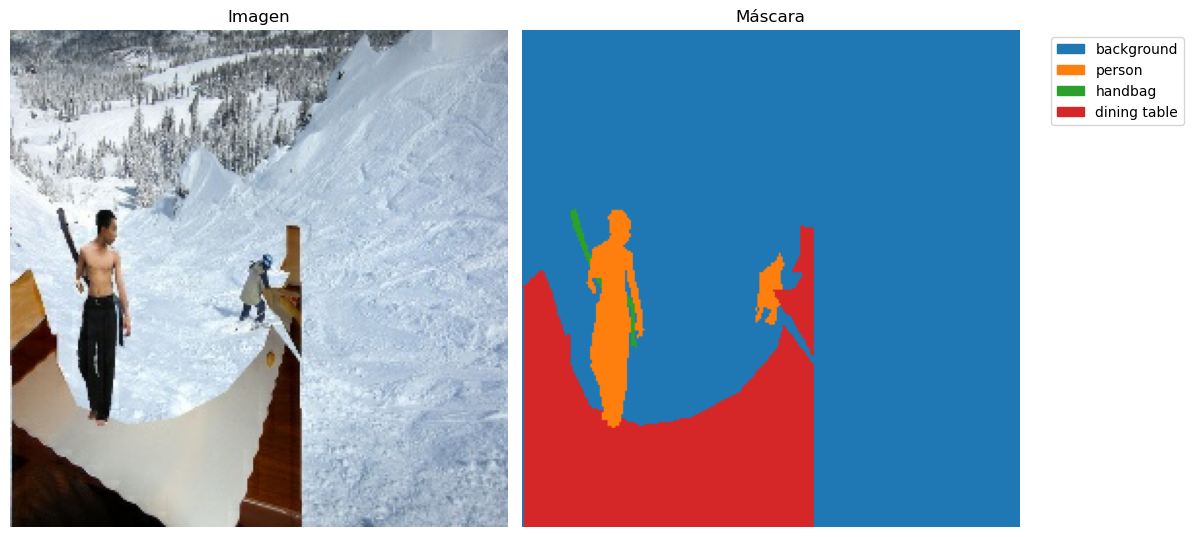

In [57]:
plot_one_hot_encoded_masks(img_batch[1,:,:,:],mask_batch[1,:,:,:], dict_channel_name)

### 2.2 Data augmentation

A continuación, se define la fase de data augmentation a aplicar al conjunto de datos para el entrenamiento del modelo.

Esta fase tiene como objetivo la aplicación de diversos cambios en las imágenes de tal forma que se permita la generación de variantes de las mismas que permitan al modelo aprender de forma correcta y se aumente la capacidad de generación del modelo.

A lo largo de este apartado se define el pipeline completo de preprocesamiento que alimentará el modelo con las imágenes, donde se incluye desde la normalización de las mismas a la fase de data augmentation.





In [ ]:
def augment_data(image,mask):
    
    ### Girado horizontal
    if tf.random.uniform(())>0.6:
        image =tf.image.flip_left_right(image)
        mask =tf.image.flip_left_right(mask)
    ### Rotacion 90º de la imagen
    if tf.random.uniform(()) > 0.95:
        ang=tf.random.uniform(minval=0,maxval=4,dtype=tf.int32,shape=[])
        image=tf.image.rot90(image,ang)
        mask=tf.image.rot90(mask,ang)


    ###Ajustes en el brillo
    if tf.random.uniform(())>0.85:
        image = tf.image.adjust_brightness(image, delta=tf.random.uniform([],-0.1,0.1))
    ###Cambios en el contraste
    if tf.random.uniform(())>0.85:
        image = tf.image.adjust_contrast(image,contrast_factor=tf.random.uniform([],0.9,1.1))


    ### Ruido  gausiano
    if tf.random.uniform(()) > 0:
        noise=tf.random.normal(shape=tf.shape(image),mean=0.0,stddev=0.05,dtype=tf.float32)
        image=tf.clip_by_value(image+noise,0.0,1.0)


    return image,mask

Se genera la función de carga completa, incluyendo data augmentation, y se aplica sobre una imagen aleatoria:

In [ ]:

######    PIPELINE DE CARGA   ######
def carga_dataset(tfrecord_path,batch_size=32,size_mezcla=100,training=True):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = raw_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(size_mezcla)
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
train_dataset = carga_dataset(tfrecord_path_train,batch_size=4,training=True)
for img_batch, mask_batch in train_dataset.take(1):
    print("Dimensiones de la primera de las imágenes del batch:",img_batch.shape)
    print("Dimensiones de la primera máscara del batch:",mask_batch.shape)

Dimensiones de la primera de las imágenes del batch: (4, 256, 256, 3)
Dimensiones de la primera máscara del batch: (4, 256, 256, 11)


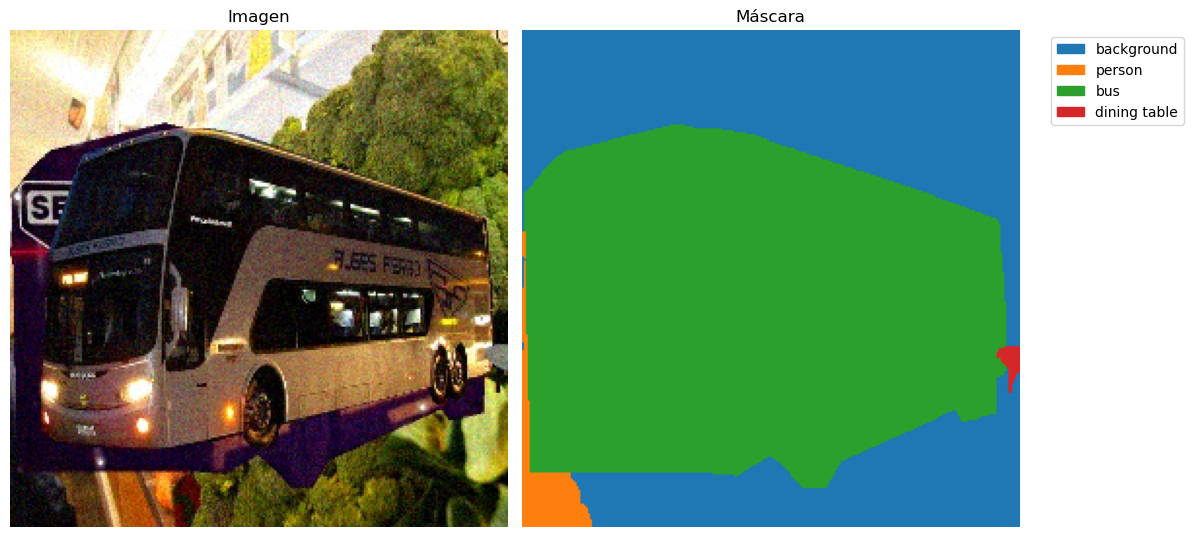

In [89]:
plot_one_hot_encoded_masks(img_batch[1,:,:,:],mask_batch[1,:,:,:], dict_channel_name)